# Higher-order Fluid Simulations on Periodic Boundaries with Φ<sub>Flow</sub>

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eloasdjo/PhiFlow/blob/Higher_order_Tutorial.ipynb)

This notebook steps demonstrates setting up a higher-order Fluid Simulation with Periodic Boundaries. For this purpose the [Taylor-Green Vortex](https://en.wikipedia.org/wiki/Taylor_Green_vortex) (TGV) will be implemented in the following.

Execute the cell below to install the [Φ<sub>Flow</sub> Python package from GitHub](https://github.com/tum-pbs/PhiFlow).


Double precision mode is activated to allow for highly accurate simulations.

In [1]:
!pip install --upgrade --quiet git+https://github.com/tum-pbs/PhiFlow@2.3-develop
from phi.jax.flow import *
from functools import partial
math.set_global_precision(64)

  Preparing metadata (setup.py) ... done


## Setting up intital conditions and analytical solution

The Taylor–Green vortex is an unsteady flow of a decaying vortex, which has an exact closed form solution of the incompressible Navier–Stokes equations in Cartesian coordinates. The solution is given by the following functions:

In [2]:
viscosity = 0.1

def exponential_decay(t):
    return math.exp(-2 * viscosity * t)

def tgv_velocity(x, t):
    sin, cos = math.sin(x), math.cos(x)
    return math.stack([cos.vector['x'] * sin.vector['y'] * exponential_decay(t),
                       - sin.vector['x'] * cos.vector['y'] * exponential_decay(t)], dim=channel('vector'))
    
def tgv_pressure(x, t):
  return -1 / 4 * (math.sum(math.cos(2 * x), 'vector')) * (exponential_decay(t) ** 2)

The predefined viscosity `vis` of `0.1` leads to a relatively low Reynoldsnumber of `1 / vis = 10` which is preferable for the TGV since higher viscosities lead to a stronger decay of the Vortex and therfor a more rapid developement in time.

First, we create a function capable of smpling the solution at arbitrary points in time and resolution. 
For that we create a qudratic DOMAIN of size `2*π` with the number of points given by `grid_resolution` in `x` and `y` direction and periodic Boundaries.
From that we create velocity vector and pressure scalar fields sampling the above solution at time `t`.
We use a Staggered Grid approach meaning we sample the pressure field at the cell centers and the velocity in [staggered form](https://tum-pbs.github.io/PhiFlow/Staggered_Grids.html).

In [3]:
def sample_tgv(grid_resolution, t):
  DOMAIN = dict(extrapolation=extrapolation.PERIODIC,
                            bounds=Box['x,y', 0:2 * math.pi, 0:2 * math.pi], x=grid_resolution, y=grid_resolution)

  velocity = StaggeredGrid(partial(tgv_velocity, t=t), **DOMAIN)
  pressure = CenteredGrid(partial(tgv_pressure, t=t), **DOMAIN)
  return velocity, pressure

Let's take a look at the initial conditions for a moderate resolution.

<Figure size 864x360 with 3 Axes>

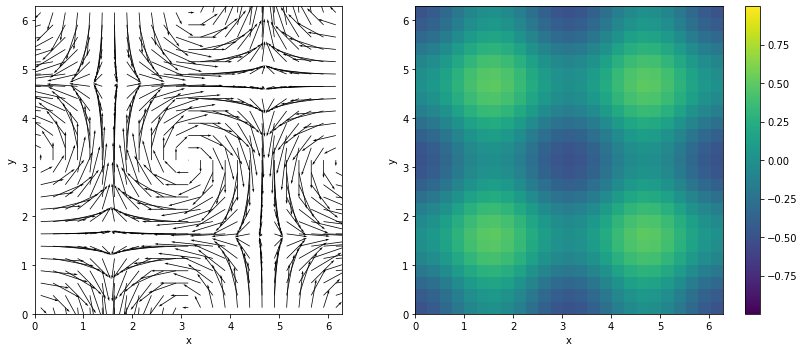

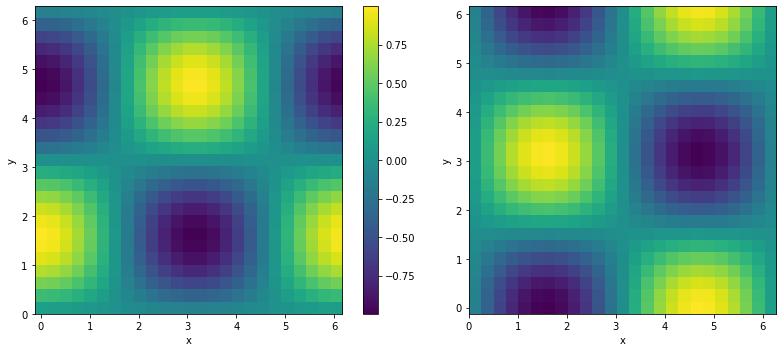

In [4]:
resolution = 25
initial_velocity, initial_pressure = sample_tgv(resolution, 0)
plot(initial_velocity, initial_pressure)
plot(initial_velocity.vector['x'], initial_velocity.vector['y']) # veclocity field in scalar representation

## Setting up a high order simulation

Now let's tend to simluate the TGV in time, we use a higher-order finite difference approach.

Firstly we create a function that discretizes the derivatives in the momentum equation incorporating advection, diffusion and a spatial gradient of the pressure.

There are a few things to note:
  1. In addition to the velocity `v` and the pressure `p`, `momentum_equation` has extra parameters which allow to configure the utilized operations mainly in terms of the order of accuracy.
  2. The parameter `adv_diff_scheme` can be set to the `'semi_lagrangian'` to perform semi-Lagranian advection and second order diffusion, apart from that 'Scheme' objects are expected.
  3.   By default `momentum_equation` uses sixth order accurate implicit advection and diffusion. Meanwhile treatment concerning the pressure are conducted using fourth-order direct Schemes. Schemes of fourth-order are in this case sufficient because the TGV is mainly diffusion driven. Direct Schemes come into play to prevent nested linear solves while enforcing the Continouity Equation
  4.   Indirect schemes require a `Solve` object. We use the Conjugate Gradient method `'CG'` since the periodic boundaries result in symmetric linear equation systems for which CG is fastest. Similar to activation of double precision mode we set the Error tolerace really low to demonstrate the full capabilites of the solver later on.
  5. while advect and diffuse functions return quanities which are already advanced in time using a first-order Euler integrator, we are interested in using a higher-order time advancement and therefor only need the corresponding amounts which is why we specify `dt=1` and substract the original velocity to revert the Euler-step






In [5]:
tol = 1e-12


def momentum_equation(v, p, adv_diff_scheme=Scheme(6, Solve('CG', tol, tol)), press_scheme=Scheme(4)):
    if adv_diff_scheme == 'semi_lagrangian':
      adv_diff_press = advect.semi_lagrangian(v, v, 1) - v
      adv_diff_press += diffuse.finite_difference(v, viscosity, 1, scheme=Scheme(2)) - v
    else:
      adv_diff_press = advect.finite_difference(v, v, 1, scheme=adv_diff_scheme) - v
      adv_diff_press += diffuse.finite_difference(v, viscosity, 1, scheme=math.copy_with(adv_diff_scheme)) - v
    
    adv_diff_press -= field.spatial_gradient(p, type=StaggeredGrid, scheme=Scheme(2))
    return adv_diff_press





Next we define a pressure treatment `pt` which enforces the countinoutiy equation, making the velocity field incompressible and advancing the pressure field in time by solving a laplace equation. Again a `scheme` parameter allows for configuration of the order of accuracy.

In [6]:
def pressure_treatment(v, p, dt, scheme=Scheme(4)):
  v, delta_p = fluid.make_incompressible(v, solve=Solve('CG', tol, tol), scheme=scheme)
  p += delta_p / dt
  return v, p

To obtain a higher-order time advancement we implement a function which performs a fourth-order accurate Runge-Kutta integrator step. And returns the new velocity and pressure fields. This requires the incorpartation of pressure treatment into the time step. The approach is inspired by [this paper](https://www.sciencedirect.com/science/article/pii/S0021999105005061) from Nikolaos A. Kampanis and John A. Ekaterinaris.

In [7]:
def time_step(velocity, pressure, dt, momep=momentum_equation, pt=pressure_treatment):
  v_1, p_1 = velocity, pressure

  rhs_1 = momep(v_1, p_1)
  v_2_old = velocity + (dt / 2) * rhs_1
  v_2, p_2 = pt(v_2_old, p_1, dt / 2)

  rhs_2 = momep(v_2, p_2)
  v_3_old = velocity + (dt / 2) * rhs_2
  v_3, p_3 = pt(v_3_old, p_2, dt / 2)

  rhs_3 = momep(v_3, p_3)
  v_4_old = velocity + dt * rhs_2
  v_4, p_4 = pt(v_4_old, p_3, dt)

  rhs_4 = momep(v_4, p_4)
  v_p1_old = velocity + (dt / 6) * (rhs_1 + 2 * rhs_2 + 2 * rhs_3 + rhs_4)
  p_p1_old = (1 / 6) * (p_1 + 2 * p_2 + 2 * p_3 + p_4)
  v_p1, p_p1 = pt(v_p1_old, p_p1_old, dt)

  return v_p1, p_p1

time_step = math.jit_compile(time_step)

Now we can finally simulate the TGV in high order accuracy.

In [8]:
v_trajectory = [initial_velocity]
p_trajectory = [initial_pressure]
velocity, pressure = initial_velocity, initial_pressure
for i in range(0):
  print(i, end=' ')
  velocity, pressure = time_step(velocity, pressure, 0.1)
  v_trajectory.append(velocity)
  p_trajectory.append(pressure)
v_trajectory = stack(v_trajectory, batch('time'))
p_trajectory = stack(p_trajectory, batch('time'))

And Visualize the result which reveals the decaying nature of the TGV time developement.

In [9]:
vis.plot(v_trajectory, p_trajectory, animate='time')

<Figure size 432x288 with 0 Axes>

In [10]:
vis.plot(v_trajectory.vector['x'], v_trajectory.vector['y'], animate='time') # velocity field in sclar representation

<Figure size 432x288 with 0 Axes>

## Setting up an order comparison


Next we want to compare the Higher-order approach to different methods of lower-order.
For that purpose we define different timestepping functions.

In [11]:
high_ord_tstep = time_step
mid_ord_tstep = partial(time_step, momep=partial(momentum_equation, adv_diff_scheme=Scheme(4), press_scheme=Scheme(4)), pt=partial(pressure_treatment, scheme=Scheme(4)))
low_ord_tstep = partial(time_step, momep=partial(momentum_equation, adv_diff_scheme=Scheme(2), press_scheme=Scheme(2)), pt=partial(pressure_treatment, scheme=Scheme(2)))
semi_lag_tstep = partial(time_step, momep=partial(momentum_equation, adv_diff_scheme='semi_lagrangian', press_scheme=Scheme(2)), pt=partial(pressure_treatment, scheme=Scheme(2)))

To factor out the time advancement and put emphasis on the spatial discretisation we use a tiny timestep size of `0.002`. We target a simulation time of 2 seconds resulting in 1000 timesteps.

We define a function capable of calculating an error trajectory for a given `resolution` and `
tstep` function.

In [12]:
dt = 0.001

def generate_error_trajectory(resolution, tstep, title):
  print(f'simulate {title} at res: {resolution}', end=': ')
  v, p = sample_tgv(resolution, 0)
  error_trajectory = [0]

  for i in range(int(t_total/dt)):
    if i % 100 == 0: print(i, end=' ')
    v, p = tstep(v, p, dt)
    analytical_solution = sample_tgv(resolution, (i+1)*dt)[0].values

    error = v.values - analytical_solution
    error_mean_L2 = math.sqrt(math.mean(error**2))
    error_mean_relative_L2 = error_mean_L2 / math.mean(abs(analytical_solution))
    error_trajectory.append(error_mean_relative_L2)

  print()
  error_trajectory = stack(error_trajectory, spatial('time'))
  return error_trajectory
    

Now we are ready to generate extensive comparison data. Depending on available computing resources and available time one can choose between generating the 'small' dataset and the 'big' one which is selected by default. While both datasets will procduce good results, the results from the 'big' are more extpressive.

In [32]:
resolutions = [5, 10, 20, 50]
# resolutions = [5, 20]
t_total = 0.5
tsteps = [high_ord_tstep, mid_ord_tstep, low_ord_tstep, semi_lag_tstep]
# tsteps = [high_ord_tstep]
names = ['high_order', 'mid_order', 'low_order', 'semi_lagrangian']
# names = ['high_order']

errors = []
for tstep, name in zip(tsteps, names):
  error_block = []
  for res in resolutions:
    error_block.append(generate_error_trajectory(res, tstep, name))
  errors.append(stack(error_block, channel(test=['res: ' + str(res) for res in resolutions])))
errors = stack(errors, batch(order=names))

# errors_high_ord = []
# for res in resolutions:
#   errors_high_ord.append(generate_error_trajectory(res, high_ord_tstep, 'high_order'))

# errors_mid_ord = []
# for res in resolutions:
#   errors_mid_ord.append(generate_error_trajectory(res, mid_ord_tstep, 'mid_order'))

# errors_low_ord = []
# for res in resolutions:
#   errors_low_ord.append(generate_error_trajectory(res, low_ord_tstep, 'low_order'))

# errors_semi_lag = []
# for res in resolutions:
#   errors_semi_lag.append(generate_error_trajectory(res, semi_lag_tstep, 'semi_lagrangian'))


simulate high_order at res: 5: 0 100 200 300 400 
simulate high_order at res: 10: 0 100 200 300 400 
simulate high_order at res: 20: 0 100 200 300 400 
simulate high_order at res: 50: 0 100 200 300 400 
simulate mid_order at res: 5: 0 100 200 300 400 
simulate mid_order at res: 10: 0 100 200 300 400 
simulate mid_order at res: 20: 0 100 200 300 400 
simulate mid_order at res: 50: 0 100 200 300 400 
simulate low_order at res: 5: 0 100 200 300 400 
simulate low_order at res: 10: 0 

/usr/local/lib/python3.8/dist-packages/phi/math/_functional.py:196: RuntimeWarning: Φ-lin: The jit-compiled function 'time_step' was traced 10 times.
Performing many traces may be slow and cause memory leaks.
Re-tracing occurs when the number or types of arguments vary or tensor shapes vary between calls.
  warnings.warn(f"""Φ-lin: The jit-compiled function '{f_name(self.f)}' was traced {len(self.traces)} times.


100 200 300 400 
simulate low_order at res: 20: 0 

/usr/local/lib/python3.8/dist-packages/phi/math/_functional.py:196: RuntimeWarning: Φ-lin: The jit-compiled function 'time_step' was traced 11 times.
Performing many traces may be slow and cause memory leaks.
Re-tracing occurs when the number or types of arguments vary or tensor shapes vary between calls.
  warnings.warn(f"""Φ-lin: The jit-compiled function '{f_name(self.f)}' was traced {len(self.traces)} times.


100 200 300 400 
simulate low_order at res: 50: 0 

/usr/local/lib/python3.8/dist-packages/phi/math/_functional.py:196: RuntimeWarning: Φ-lin: The jit-compiled function 'time_step' was traced 12 times.
Performing many traces may be slow and cause memory leaks.
Re-tracing occurs when the number or types of arguments vary or tensor shapes vary between calls.
  warnings.warn(f"""Φ-lin: The jit-compiled function '{f_name(self.f)}' was traced {len(self.traces)} times.


100 200 300 400 
simulate semi_lagrangian at res: 5: 0 

/usr/local/lib/python3.8/dist-packages/phi/math/_functional.py:196: RuntimeWarning: Φ-lin: The jit-compiled function 'time_step' was traced 13 times.
Performing many traces may be slow and cause memory leaks.
Re-tracing occurs when the number or types of arguments vary or tensor shapes vary between calls.
  warnings.warn(f"""Φ-lin: The jit-compiled function '{f_name(self.f)}' was traced {len(self.traces)} times.


100 200 300 400 
simulate semi_lagrangian at res: 10: 0 

/usr/local/lib/python3.8/dist-packages/phi/math/_functional.py:196: RuntimeWarning: Φ-lin: The jit-compiled function 'time_step' was traced 14 times.
Performing many traces may be slow and cause memory leaks.
Re-tracing occurs when the number or types of arguments vary or tensor shapes vary between calls.
  warnings.warn(f"""Φ-lin: The jit-compiled function '{f_name(self.f)}' was traced {len(self.traces)} times.


100 200 300 400 
simulate semi_lagrangian at res: 20: 0 

/usr/local/lib/python3.8/dist-packages/phi/math/_functional.py:196: RuntimeWarning: Φ-lin: The jit-compiled function 'time_step' was traced 15 times.
Performing many traces may be slow and cause memory leaks.
Re-tracing occurs when the number or types of arguments vary or tensor shapes vary between calls.
  warnings.warn(f"""Φ-lin: The jit-compiled function '{f_name(self.f)}' was traced {len(self.traces)} times.


100 200 300 400 
simulate semi_lagrangian at res: 50: 0 

/usr/local/lib/python3.8/dist-packages/phi/math/_functional.py:196: RuntimeWarning: Φ-lin: The jit-compiled function 'time_step' was traced 16 times.
Performing many traces may be slow and cause memory leaks.
Re-tracing occurs when the number or types of arguments vary or tensor shapes vary between calls.
  warnings.warn(f"""Φ-lin: The jit-compiled function '{f_name(self.f)}' was traced {len(self.traces)} times.


100 200 300 400 


<Figure size 864x360 with 4 Axes>

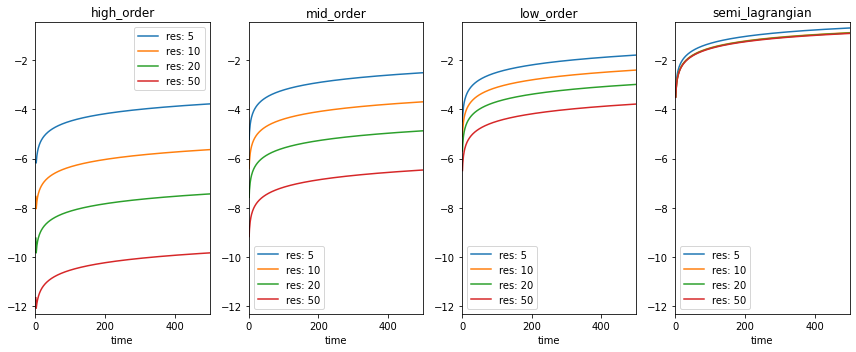

In [34]:
plot(math.log10(errors))

Let's take a look at how the errors are developing in time

To finish off we visualise the final errors with respect to the resolution. This allows us to determine the order of accuracy.

<Figure size 864x360 with 1 Axes>

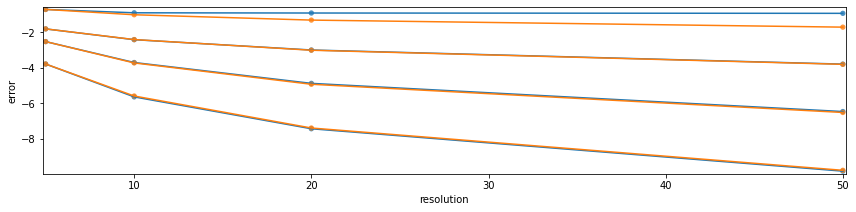

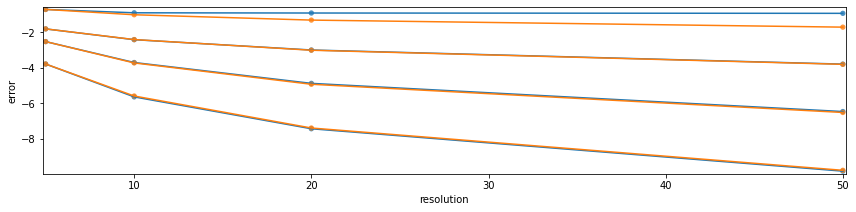

In [224]:
ord_of_acc = wrap([6, 4, 2, 1], batch(order=names))

final_errors = math.rename_dims(errors.time[-1], 'test', spatial('line'))
final_errors = vec(resolution=(stack(resolutions, spatial('line'))), error=final_errors)
ideal_line = stack([final_errors.line[0]] + [vec(resolution=resolutions[i], error=final_errors.line[0].vector['error']*(resolutions[0]/resolutions[i])**ord_of_acc) for i in range(1, final_errors.line.size)], spatial('line'))

# final_errors = concat([final_errors, ideal_line], 'order')
final_errors = stack([final_errors, ideal_line], channel('ideal'))
final_errors = math.where(wrap([0,1], channel(vector='resolution, error')), math.log10(final_errors), final_errors)
final_errors = math.rename_dims(final_errors, 'order', instance(order=names))
plot(PointCloud(Sphere(final_errors, radius=wrap([0.15, 0.15, 0.15, 0.15], instance(order=names))), color=wrap(list(range(final_errors.ideal.size)), channel('ideal'))))
plot(PointCloud(Sphere(final_errors, radius=.15), color=wrap(list(range(final_errors.ideal.size)), channel('ideal'))))



    